14/01/25 - 10:48:20 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000195283094225 : 0.01109036663292906


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Simulated rhoa 171 [95.1741666964271,...,19.73671216731079] 97.44191180744154
Filtered rhoa 171 [95.1741666964271,...,19.73671216731079] 97.44191180744154


14/01/25 - 10:48:21 - pyGIMLi - INFO - Found 2 regions.
14/01/25 - 10:48:21 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
14/01/25 - 10:48:21 - pyGIMLi - INFO - Found 2 regions.
14/01/25 - 10:48:21 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
14/01/25 - 10:48:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
14/01/25 - 10:48:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
14/01/25 - 10:48:21 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1212 Cells: 2236 Boundaries: 1770
14/01/25 - 10:48:21 - pyGIMLi - INFO - Use median(data values)=57.65200068640407




[-8. -7. -6. -5. -4. -3. -2. -1.  0.]


14/01/25 - 10:48:27 - pyGIMLi - INFO - Found 2 regions.
14/01/25 - 10:48:27 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (0) set to background.
14/01/25 - 10:48:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
14/01/25 - 10:48:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
14/01/25 - 10:48:27 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2014 Cells: 2884 Boundaries: 2478
14/01/25 - 10:48:27 - pyGIMLi - INFO - Use median(data values)=57.65200068640407


AttributeError: 'ClassicInversion' object has no attribute 'getChi2'

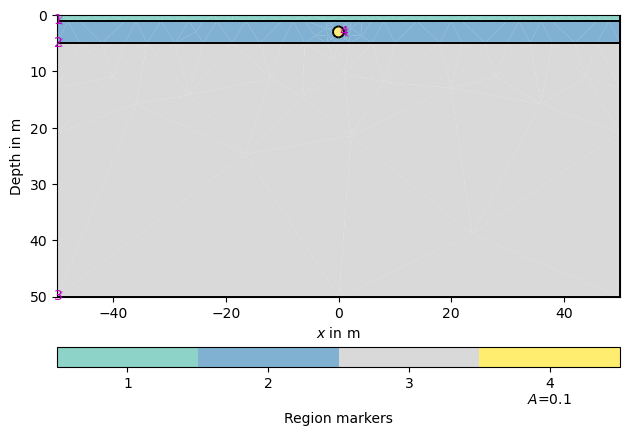

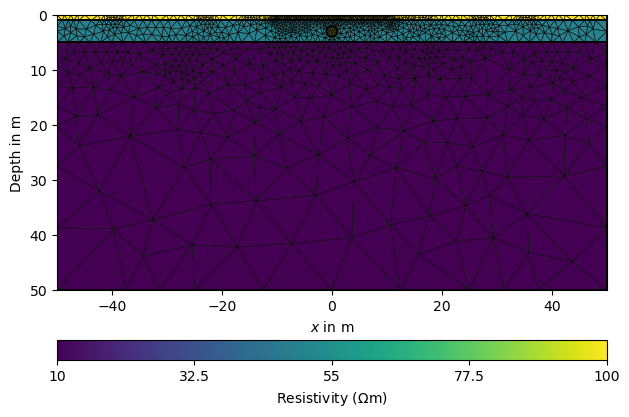

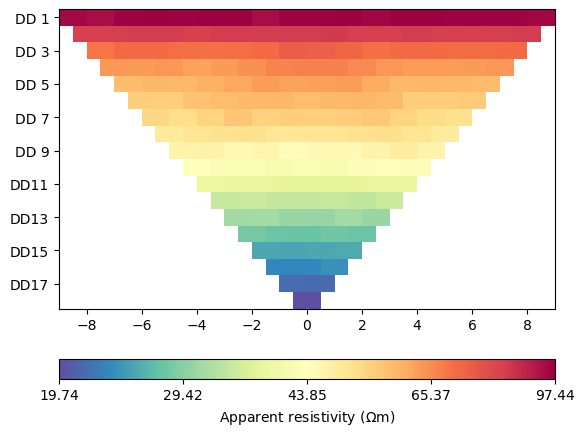

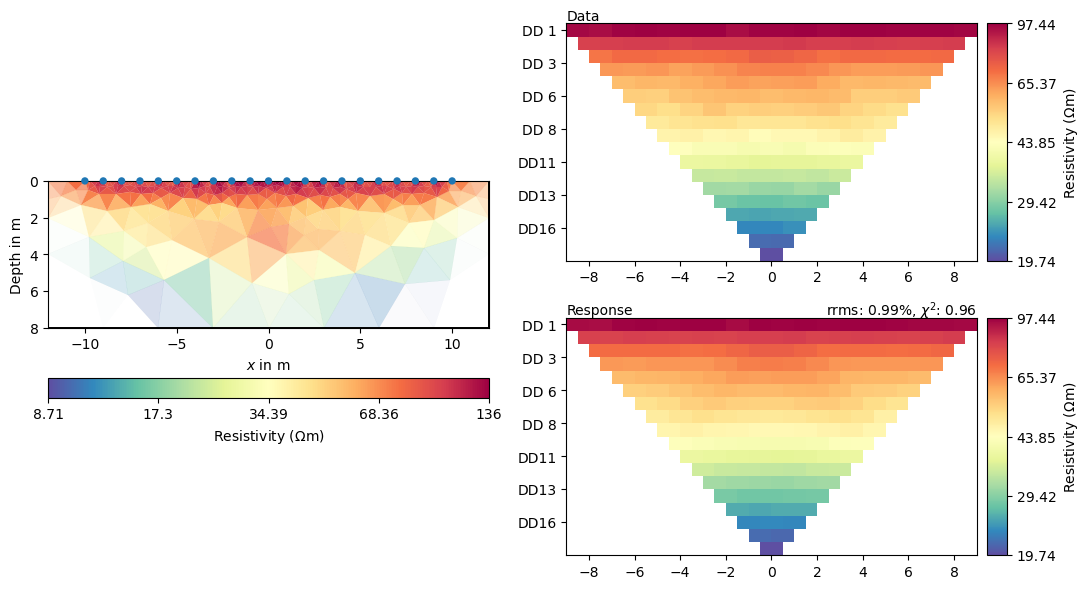

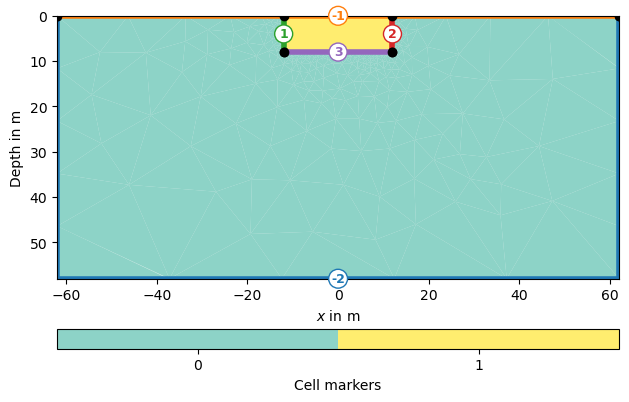

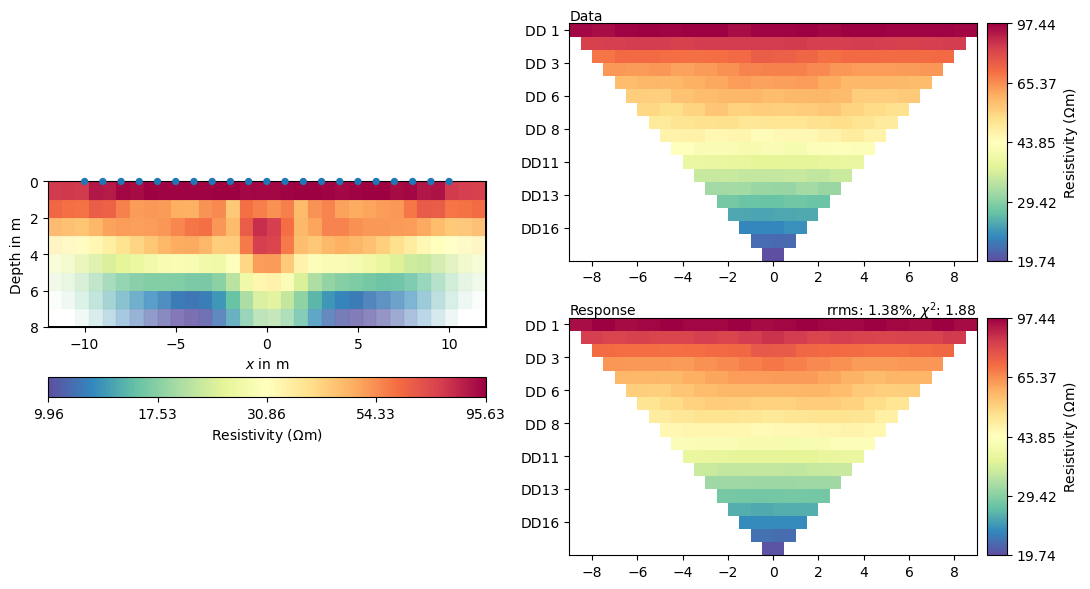

In [1]:
# -*- coding: utf-8 -*-
from pygimli.physics import ert
import pygimli as pg
import pygimli.meshtools as mt  # save space

world = mt.createWorld(start=[-50, 0], end=[50, -50], layers=[-1, -5],
                       worldMarker=True)

# Create some heterogeneous circular anomaly
block = mt.createCircle(pos=[0, -3.], radius=1, marker=4, boundaryMarker=10,
                        area=0.1)

# Merge geometry definition into a Piecewise Linear Complex (PLC)
geom = mt.mergePLC([world, block])

# Optional: show the geometry
pg.show(geom)

scheme = ert.createData(elecs=pg.utils.grange(start=-10, end=10, n=21),
                       schemeName='dd')

for pos in scheme.sensorPositions():
    geom.createNode(pos)
    geom.createNode(pos + pg.RVector3(0, -0.1))

mesh = mt.createMesh(geom, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1, 100.],
          [2, 50.],
          [3, 10.],
          [4, 100.]]

# Optional: take a look at the mesh
pg.show(mesh, data=rhomap, label='Resistivity $(\Omega$m)', showMesh=True)

mgr = ert.ERTManager()

# Perform the modeling with the mesh and the measuring scheme itself
# and return a data container with apparent resistivity values,
# geometric factors and estimated data errors specified by the noise setting.
# The noise is also added to the data.
data = ert.simulate(mesh, res=rhomap, scheme=scheme, noiseLevel=1,
                    noiseAbs=1e-6)

# Optional: you can filter all values and tokens in the data container.
print('Simulated rhoa', data('rhoa'), max(data('rhoa')))

# Its possible that there are some negative data values due to noise and
# huge geometric factors. So we need to remove them
data.markInvalid(data('rhoa') < 0)
print('Filtered rhoa', data('rhoa'), max(data('rhoa')))
data.removeInvalid()

# Optional: save the data for further use
data.save('simple.dat')

# Optional: take a look at the data
ert.show(data)

# Run the ERTManager to invert the modeled data.
# The necessary inversion mesh is generated automatic.
model = mgr.invert(data, paraDX=0.3, maxCellArea=0.2, lam=20)

# Let the ERTManger show you the model and fitting results of the last
# successful run.
# Show data, model response, and model
mgr.showResultAndFit()
# %%
import numpy as np
x = pg.utils.grange(start=-12, end=12, n=33)
# y = -pg.utils.grange(0.5, 8, n=8, log=True)
# y = pg.cat(pg.Vector(1, 0.), y)
y = np.arange(-8., 0.1, 1.0)
print(y)
grid = pg.createGrid(x=x, y=y, marker=1)
# %
mesh = pg.meshtools.appendTriangleBoundary(grid, xbound=50, ybound=50, marker=0)
pg.show(mesh, markers=True)
# %%
model = mgr.invert(data, mesh=mesh, lam=20)
mgr.showResultAndFit()

chi2 = mgr.inv.getChi2()

print(chi2)
# Stop the script here and wait until all figure are closed.
pg.wait()